# Dataset: Oxford Flowers 102
8,189 images

102 flower categories

Samples per class	Between 40 and 258 images

Image size	Varies (need resizing)

Format	JPEG images with a .mat split file

Avantages :

Images de haute résolution avec beaucoup de détails
Diversité de couleurs, textures et formes
Bonne taille de dataset (ni trop petit, ni trop grand)
Fond relativement homogène qui facilite l'apprentissage


Pourquoi ce dataset : Les images de fleurs sont idéales pour tester la reconstruction car elles contiennent des motifs répétitifs mais aussi des détails complexes. Le modèle devra apprendre à reconstruire les textures fines des pétales, les gradients de couleur, et les structures des fleurs.



# Modèle: ViT-Base Patch16-224
préentraîné sur ImageNet:

Pourquoi ce modèle :

Architecture standard avec une taille de patch de 16×16 pixels

Préentraîné sur un grand dataset (ImageNet)

Bon équilibre entre performance et complexité

Très bien supporté par les bibliothèques comme Hugging Face


Spécifications :

12 couches de transformer

12 têtes d'attention par couche

Dimension cachée de 768

Nombre total de paramètres : ~86M

In [1]:
!pip install tensorflow

In [2]:
!pip install tf-keras

2025-04-18 18:19:08.701879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745000348.897623      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745000348.950156      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.4YHITM_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.4YHITM_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.4YHITM_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


I0000 00:00:1745000398.654753      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


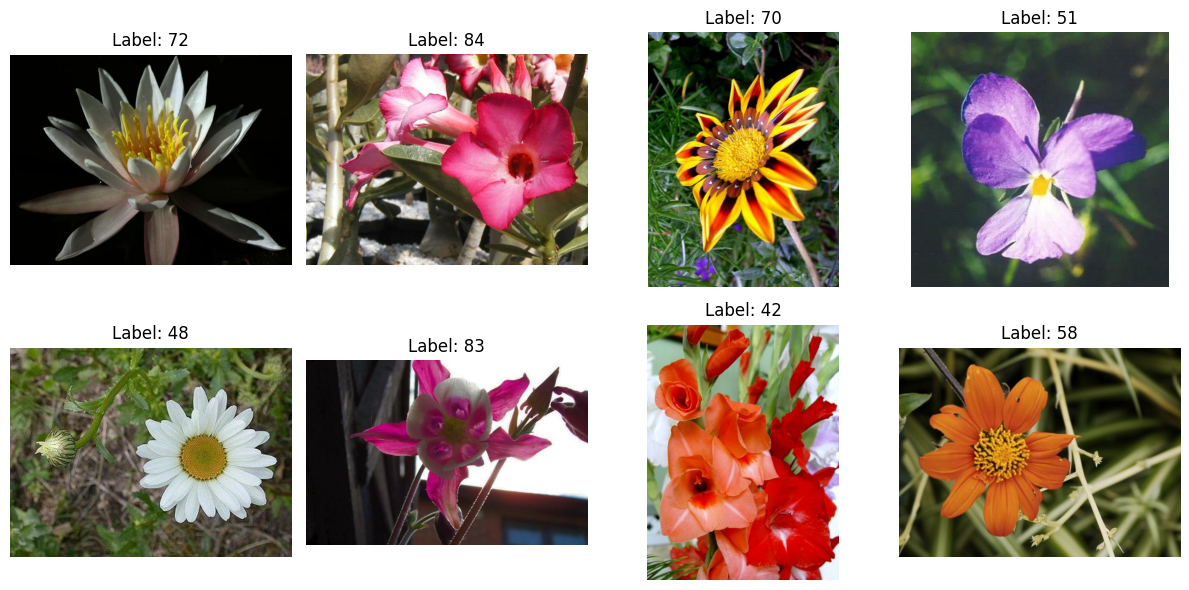

In [3]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the dataset (auto-downloads if needed)
dataset, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
train_ds = dataset['train']

# Display a few images
plt.figure(figsize=(12, 6))

for i, (img, label) in enumerate(train_ds.take(8)):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label.numpy()}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, callbacks
import tensorflow_datasets as tfds
from transformers import TFViTModel
from skimage.metrics import structural_similarity as ssim
import time
import os

'''# Configurez la mémoire GPU pour éviter OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)'''

# Configuration
IMAGE_SIZE = 224  # Taille standard pour ViT
PATCH_SIZE = 16   # Taille des patchs pour ViT
BATCH_SIZE = 32   # Réduit pour éviter les problèmes de mémoire
AUTOTUNE = tf.data.AUTOTUNE
LEARNING_RATE = 1e-4
EPOCHS = 20
DATASET_NAME = "oxford_flowers102"
CHECKPOINT_PATH = "./checkpoints/vit_reconstruction"

# Chargement et préparation du dataset

Chargement du dataset oxford_flowers102...
Nombre d'images d'entraînement: 1020
Nombre d'images de validation: 1020
Taille des images: (None, None, 3)
Nombre de classes: 102


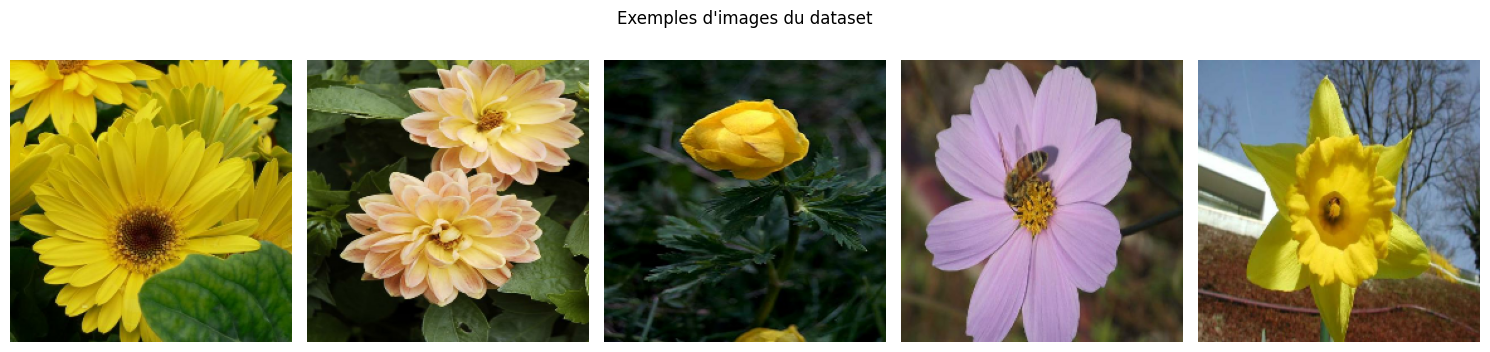

In [5]:
print(f"Chargement du dataset {DATASET_NAME}...")
(train_ds, val_ds), ds_info = tfds.load(
    DATASET_NAME,
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Affichage des informations du dataset
print(f"Nombre d'images d'entraînement: {ds_info.splits['train'].num_examples}")
print(f"Nombre d'images de validation: {ds_info.splits['validation'].num_examples}")
print(f"Taille des images: {ds_info.features['image'].shape}")
print(f"Nombre de classes: {ds_info.features['label'].num_classes}")

def preprocess_image(image, label):
    """
    Prétraite les images pour le modèle ViT:
    1. Redimensionne à la taille attendue par ViT (224x224)
    2. Normalise les valeurs des pixels entre 0 et 1
    3. Utilise l'image originale comme cible pour la reconstruction
    """
   # Gestion des images en niveaux de gris ou avec plus de 3 canaux
    if tf.shape(image)[-1] != 3:
        image = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(image))


    # Redimensionnement et normalisation
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    # Pour la tâche de reconstruction, l'entrée et la sortie sont les mêmes image
    return image, image

# Préparation des datasets
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

# Optimisation des performances
train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Visualisation d'exemples d'images
def visualize_dataset_samples(dataset, num_images=5):
    """Affiche quelques exemples d'images du dataset."""
    plt.figure(figsize=(15, 4))
    for i, (image, _) in enumerate(dataset.unbatch().take(num_images)):
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle("Exemples d'images du dataset")
    plt.show()

visualize_dataset_samples(train_ds)

# Implémentation des stratégies de masquage

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

def random_masking(images, masking_ratio=0.5):
    batch_size = tf.shape(images)[0]
    height = tf.shape(images)[1]
    width = tf.shape(images)[2]
    num_channels = tf.shape(images)[3]

    h, w = height // PATCH_SIZE, width // PATCH_SIZE
    num_patches = h * w
    num_masked = tf.cast(masking_ratio * tf.cast(num_patches, tf.float32), tf.int32)

    # Masque initial pour tout le batch
    mask = tf.zeros((batch_size, num_patches), dtype=tf.float32)

    def mask_single_image(i, mask):
        random_indices = tf.random.shuffle(tf.range(num_patches))[:num_masked]
        updates = tf.ones_like(random_indices, dtype=tf.float32)
        indices = tf.stack([tf.fill([num_masked], i), random_indices], axis=1)
        return tf.tensor_scatter_nd_update(mask, indices, updates)

    for i in tf.range(batch_size):
        mask = mask_single_image(i, mask)

    mask = tf.reshape(mask, (batch_size, h, w, 1))
    mask = tf.image.resize(mask, (height, width), method='nearest')
    masks_for_multiplication = tf.repeat(mask, repeats=num_channels, axis=-1)
    masked_images = images * (1 - masks_for_multiplication)
    return masked_images, mask


def column_masking(images, masking_ratio=0.5):
    batch_size = tf.shape(images)[0]
    num_columns = tf.cast(masking_ratio * tf.cast(IMAGE_SIZE, tf.float32), tf.int32)

    mask = tf.zeros([IMAGE_SIZE, IMAGE_SIZE, 1], dtype=tf.float32)
    col_indices = tf.random.shuffle(tf.range(IMAGE_SIZE))[:num_columns]

    for col_idx in col_indices:
        indices = tf.stack([
            tf.range(IMAGE_SIZE),
            tf.fill([IMAGE_SIZE], col_idx),
            tf.zeros([IMAGE_SIZE], dtype=tf.int32)
        ], axis=1)
        mask = tf.tensor_scatter_nd_update(mask, indices, tf.ones([IMAGE_SIZE], dtype=tf.float32))

    masks = tf.tile(tf.expand_dims(mask, 0), [batch_size, 1, 1, 1])
    masked_images = images * (1 - masks)
    return masked_images, masks


def row_masking(images, masking_ratio=0.5):
    batch_size = tf.shape(images)[0]
    num_rows = tf.cast(masking_ratio * tf.cast(IMAGE_SIZE, tf.float32), tf.int32)
    row_indices = tf.random.shuffle(tf.range(IMAGE_SIZE))[:num_rows]

    mask = tf.zeros([IMAGE_SIZE, IMAGE_SIZE, 1], dtype=tf.float32)

    for row_idx in row_indices:
        indices = tf.stack([
            tf.fill([IMAGE_SIZE], row_idx),
            tf.range(IMAGE_SIZE),
            tf.zeros([IMAGE_SIZE], dtype=tf.int32)
        ], axis=1)
        mask = tf.tensor_scatter_nd_update(mask, indices, tf.ones([IMAGE_SIZE], dtype=tf.float32))

    masks = tf.tile(tf.expand_dims(mask, 0), [batch_size, 1, 1, 1])
    masked_images = images * (1 - masks)
    return masked_images, masks




In [7]:
def importance_masking(images, masking_ratio=0.5):
    """
    Masks parts of the image based on importance (gradient magnitude).
    Less important (low gradient) areas are masked first.

    Args:
        images: Batch of images, shape [batch_size, height, width, channels]
        masking_ratio: Percentage of pixels to mask

    Returns:
        masked_images: Images with less important areas masked
        masks: Binary masks where 1 indicates masked regions
    """
    batch_size = tf.shape(images)[0]

    # Calculate importance based on gradient magnitude (Sobel filter)
    def calculate_importance(image):
        # Convert to grayscale for importance calculation
        gray = tf.image.rgb_to_grayscale(image)

        # Apply Sobel filters to detect edges (high gradient areas)
        sobel_x = tf.nn.conv2d(tf.expand_dims(gray, 0),
                              tf.reshape(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=tf.float32),
                                        [3, 3, 1, 1]),
                              strides=[1, 1, 1, 1], padding='SAME')[0]

        sobel_y = tf.nn.conv2d(tf.expand_dims(gray, 0),
                              tf.reshape(tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=tf.float32),
                                        [3, 3, 1, 1]),
                              strides=[1, 1, 1, 1], padding='SAME')[0]

        # Compute gradient magnitude
        gradient_magnitude = tf.sqrt(tf.square(sobel_x) + tf.square(sobel_y))

        # Normalize to [0, 1]
        gradient_magnitude = gradient_magnitude / tf.reduce_max(gradient_magnitude)
        return gradient_magnitude

    # Process each image in the batch
    masked_images_list = []
    masks_list = []

    for i in range(batch_size):
        image = images[i]
        importance_map = calculate_importance(image)

        # Flatten importance map for thresholding
        flat_importance = tf.reshape(importance_map, [-1])

        # Determine threshold value based on masking ratio
        # We want to mask low-importance areas, so we find the value below which
        # masking_ratio percent of pixels fall
        k = tf.cast(tf.math.round(masking_ratio * tf.cast(tf.size(flat_importance), tf.float32)), tf.int32)
        threshold = tf.sort(flat_importance)[k]

        # Create mask (1 for pixels to mask, 0 for pixels to keep)
        mask = tf.cast(importance_map <= threshold, tf.float32)

        # Apply mask to image (mask out low-importance areas)
        mask_3channel = tf.tile(mask, [1, 1, 3])
        masked_image = image * (1 - mask_3channel)

        masked_images_list.append(masked_image)
        masks_list.append(mask)

    return tf.stack(masked_images_list), tf.stack(masks_list)

I0000 00:00:1745000409.924225      31 cuda_dnn.cc:529] Loaded cuDNN version 90300


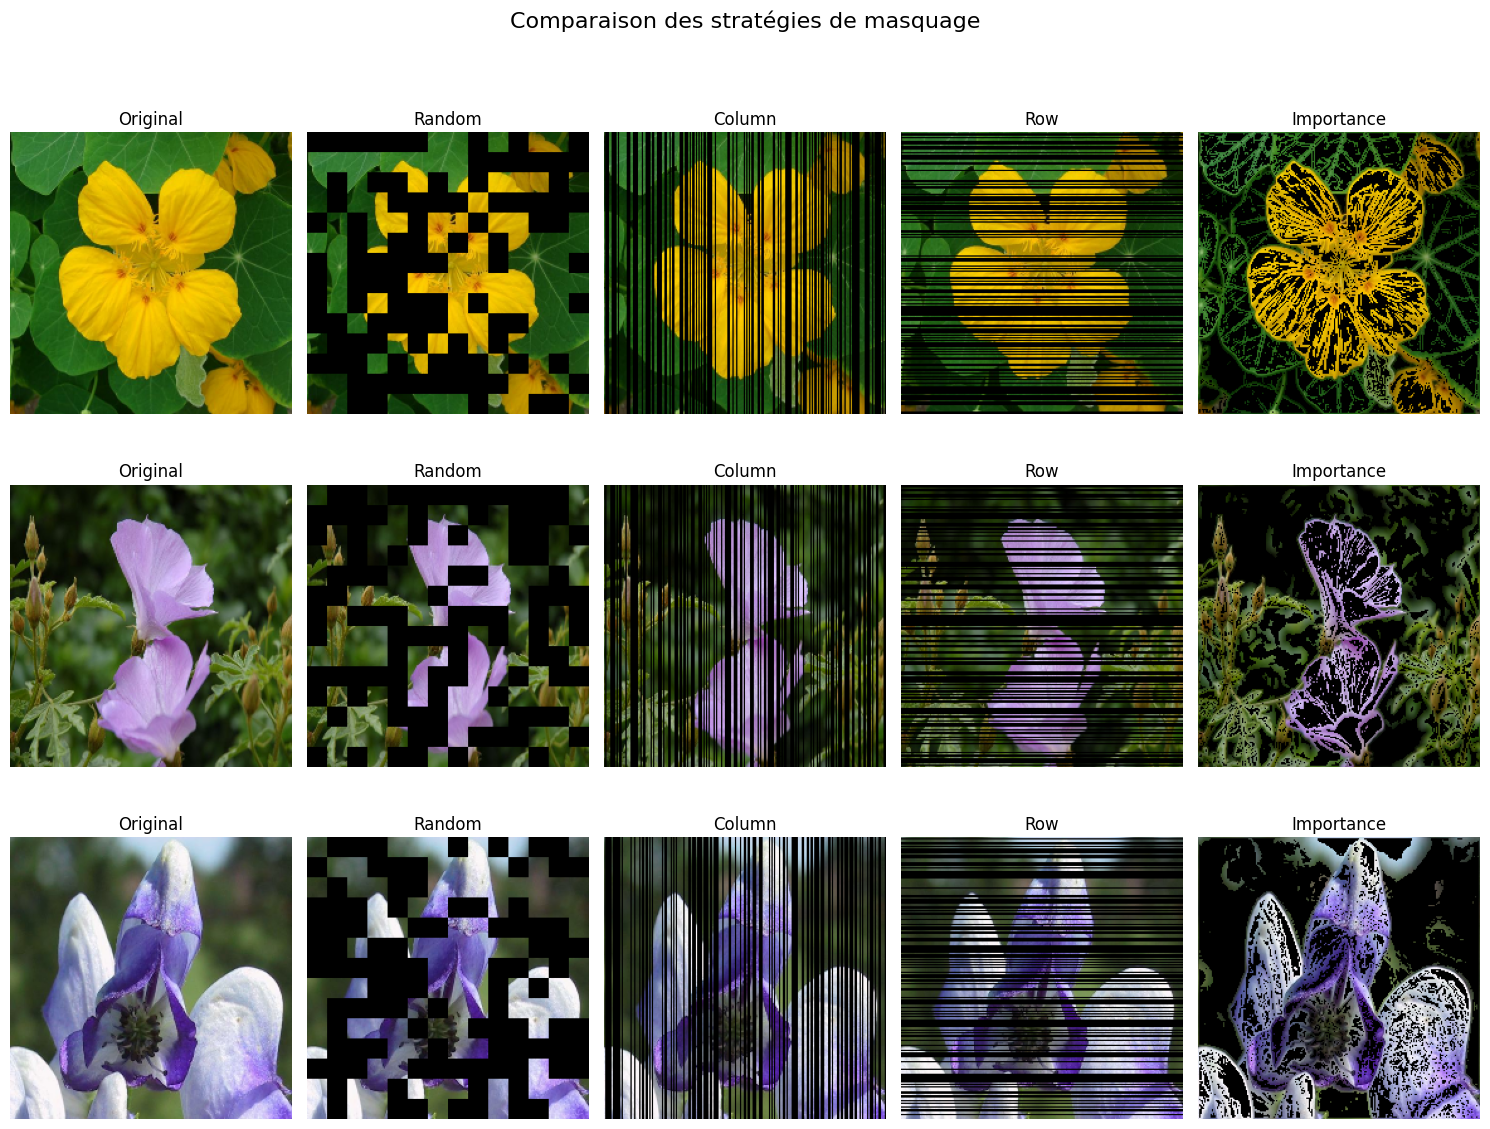

In [8]:
def visualize_masking_strategies(images, strategies):
    num_images = min(3, images.shape[0])
    num_strategies = len(strategies)

    plt.figure(figsize=(15, 4 * num_images))

    for img_idx in range(num_images):
        plt.subplot(num_images, num_strategies + 1, img_idx * (num_strategies + 1) + 1)
        plt.imshow(images[img_idx].numpy())
        plt.title("Original")
        plt.axis('off')

        for i, (name, func) in enumerate(strategies.items()):
            masked_img, _ = func(tf.expand_dims(images[img_idx], 0), masking_ratio=0.5)
            plt.subplot(num_images, num_strategies + 1, img_idx * (num_strategies + 1) + i + 2)
            plt.imshow(masked_img[0].numpy())
            plt.title(name)
            plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Comparaison des stratégies de masquage", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()


# Exemple : images à visualiser depuis val_ds
sample_images = next(iter(val_ds.unbatch().batch(5)))[0]

masking_strategies = {
    "Random": lambda x, masking_ratio=0.5: random_masking(x, masking_ratio),
    "Column": lambda x, masking_ratio=0.5: column_masking(x, masking_ratio),
    "Row": lambda x, masking_ratio=0.5: row_masking(x, masking_ratio),
    "Importance": lambda x, masking_ratio=0.5: importance_masking(x, masking_ratio)
}

visualize_masking_strategies(sample_images, masking_strategies)

# Adaptation du modèle ViT pour la reconstruction

In [9]:
def create_vit_reconstruction_model():
    """
    Crée un modèle de reconstruction d'images basé sur ViT.

    Architecture:
    1. ViT préentraîné pour l'encodage des patchs d'image
    2. Couches de décodage pour reconstruire l'image originale

    Retourne:
        model: Le modèle TensorFlow compilé
    """
    print("Chargement du modèle ViT préentraîné...")

    # Entrée: image masquée
    inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # Créer une couche personnalisée au lieu d'utiliser Lambda
    class ViTFeatureExtractor(tf.keras.layers.Layer):
        def __init__(self):

          super(ViTFeatureExtractor, self).__init__()
          self.vit = TFViTModel.from_pretrained(
               "google/vit-base-patch16-224",
            from_pt=True
        )

        def call(self, inputs):
        #Explicitly format inputs for the ViT model - switching to channels-first format
        # As ViT expects [B, C, H, W] but will transpose internally
            inputs_channels_first = tf.transpose(inputs, perm=[0, 3, 1, 2])
            # Override the internal transpose by setting a custom attribute
        # This is a hack to prevent the double transposition
            with tf.name_scope('vit_forward'):
                outputs = self.vit({"pixel_values": inputs_channels_first}, training=False)

            return outputs.last_hidden_state

        def compute_output_shape(self, input_shape):

            batch_size = input_shape[0]
            return (batch_size, 197, 768)

    # Utiliser notre extracteur de caractéristiques ViT
    vit_extractor = ViTFeatureExtractor()
    vit_outputs = vit_extractor(inputs)

    # Suppression du token [CLS] (le premier token)
    class RemoveClsToken(tf.keras.layers.Layer):
        def call(self, inputs):
            return inputs[:, 1:, :]

        def compute_output_shape(self, input_shape):
            return (input_shape[0], input_shape[1] - 1, input_shape[2])

    x = RemoveClsToken()(vit_outputs)

    # Reshape pour obtenir une représentation spatiale
    PATCH_SIZE = 16  # Taille des patchs pour ViT-Base
    num_patches_side = IMAGE_SIZE // PATCH_SIZE
    hidden_dim = 768  # Dimension cachée standard de ViT-Base

    # Reshape en représentation spatiale [B, √num_patches, √num_patches, hidden_dim]
    x = tf.keras.layers.Reshape((num_patches_side, num_patches_side, hidden_dim))(x)

    # Décodeur: série de couches de convolution transposée
    # 14×14 → 28×28
    x = tf.keras.layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # 28×28 → 56×56
    x = tf.keras.layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # 56×56 → 112×112
    x = tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # 112×112 → 224×224
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Couche finale: reconstruction de l'image RGB
    outputs = tf.keras.layers.Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')(x)

    # Création du modèle
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compilation
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae', 'mse']
    )

    return model

# Préparation des données pour l'entraînement avec masquage

In [10]:
'''class MaskingDataGenerator(tf.keras.utils.Sequence):
    """
    Générateur de données qui applique dynamiquement le masquage aux images.
    Cela permet de varier les masques à chaque époque pour une meilleure
    généralisation du modèle.
    """
    def __init__(self, dataset, masking_function, batch_size=32):
        self.dataset = dataset
        self.masking_function = masking_function
        self.batch_size = batch_size

        # Convertir le dataset TensorFlow en liste de batches
        self.batches = list(self.dataset)

    def __len__(self):
        return len(self.batches)

    def __getitem__(self, idx):
        # Récupérer un batch d'images originales
        original_images, _ = self.batches[idx]

        # Appliquer le masquage
        masked_images, _ = self.masking_function(original_images)

        # Retourner les images masquées comme entrées et les originales comme cibles
        return masked_images, original_images'''

'class MaskingDataGenerator(tf.keras.utils.Sequence):\n    """\n    Générateur de données qui applique dynamiquement le masquage aux images.\n    Cela permet de varier les masques à chaque époque pour une meilleure\n    généralisation du modèle.\n    """\n    def __init__(self, dataset, masking_function, batch_size=32):\n        self.dataset = dataset\n        self.masking_function = masking_function\n        self.batch_size = batch_size\n\n        # Convertir le dataset TensorFlow en liste de batches\n        self.batches = list(self.dataset)\n\n    def __len__(self):\n        return len(self.batches)\n\n    def __getitem__(self, idx):\n        # Récupérer un batch d\'images originales\n        original_images, _ = self.batches[idx]\n\n        # Appliquer le masquage\n        masked_images, _ = self.masking_function(original_images)\n\n        # Retourner les images masquées comme entrées et les originales comme cibles\n        return masked_images, original_images'

In [11]:
# Optimize the MaskingDataGenerator for speed
class OptimizedMaskingDataGenerator(tf.keras.utils.Sequence):
    """
    Optimized generator that pre-computes some batches and uses a worker pool
    for faster data loading and masking.
    """
    def __init__(self, dataset, masking_function, batch_size=32, buffer_size=4):
        self.dataset = dataset
        self.masking_function = masking_function
        self.batch_size = batch_size
        self.buffer_size = min(buffer_size, 8)  # Cap buffer size

        # Convert dataset to batches
        self.batches = list(self.dataset)
        self.length = len(self.batches)

        # Pre-compute some batches for speed
        self.buffer = {}

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Check if this batch is in our buffer
        if idx in self.buffer:
            return self.buffer[idx]

        # Get original images
        original_images, _ = self.batches[idx]

        # Apply masking
        masked_images, _ = self.masking_function(original_images)

        # Cache in buffer (with LRU-like behavior)
        if len(self.buffer) >= self.buffer_size:
            # Remove oldest item
            oldest_key = next(iter(self.buffer))
            del self.buffer[oldest_key]

        self.buffer[idx] = (masked_images, original_images)
        return masked_images, original_images

    def on_epoch_end(self):
        # Clear buffer between epochs as masking should vary
        self.buffer = {}

# Fonctions d'entraînement, d'évaluation et de visualisation

In [12]:
'''def train_model_with_masking(model, train_ds, val_ds, masking_function, epochs=10, masking_name="random"):
    """
    Entraîne le modèle avec une stratégie de masquage spécifique.

    Arguments:
        model: Modèle de reconstruction
        train_ds, val_ds: Datasets d'entraînement et de validation
        masking_function: Fonction de masquage à appliquer
        epochs: Nombre d'époques d'entraînement
        masking_name: Nom de la stratégie de masquage (pour les logs)

    Retourne:
        history: Historique d'entraînement
    """
    print(f"\n=== Entraînement avec masquage {masking_name} ===")

    # Préparation des générateurs de données avec masquage
    train_gen = MaskingDataGenerator(train_ds, masking_function, BATCH_SIZE)
    val_gen = MaskingDataGenerator(val_ds, masking_function, BATCH_SIZE)

    # Création du répertoire pour les checkpoints
    os.makedirs(f"{CHECKPOINT_PATH}/{masking_name}", exist_ok=True)

    # Callbacks
    callbacks_list = [
        # Sauvegarde du meilleur modèle
        callbacks.ModelCheckpoint(
            filepath=f"{CHECKPOINT_PATH}/{masking_name}/best_model.h5",
            monitor='val_loss',
            save_best_only=True
        ),
        # Réduction du learning rate si le plateau est atteint
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        # Arrêt anticipé si aucune amélioration
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        # TensorBoard pour visualiser les progrès
        callbacks.TensorBoard(
            log_dir=f"./logs/{masking_name}",
            histogram_freq=1
        )
    ]

    # Entraînement
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks_list
    )

    return history'''

'def train_model_with_masking(model, train_ds, val_ds, masking_function, epochs=10, masking_name="random"):\n    """\n    Entraîne le modèle avec une stratégie de masquage spécifique.\n\n    Arguments:\n        model: Modèle de reconstruction\n        train_ds, val_ds: Datasets d\'entraînement et de validation\n        masking_function: Fonction de masquage à appliquer\n        epochs: Nombre d\'époques d\'entraînement\n        masking_name: Nom de la stratégie de masquage (pour les logs)\n\n    Retourne:\n        history: Historique d\'entraînement\n    """\n    print(f"\n=== Entraînement avec masquage {masking_name} ===")\n\n    # Préparation des générateurs de données avec masquage\n    train_gen = MaskingDataGenerator(train_ds, masking_function, BATCH_SIZE)\n    val_gen = MaskingDataGenerator(val_ds, masking_function, BATCH_SIZE)\n\n    # Création du répertoire pour les checkpoints\n    os.makedirs(f"{CHECKPOINT_PATH}/{masking_name}", exist_ok=True)\n\n    # Callbacks\n    callback

In [13]:
def evaluate_reconstruction(model, images, masking_function):
    """
    Évalue la qualité de reconstruction et calcule les métriques.

    Arguments:
        model: Modèle entraîné
        images: Batch d'images à évaluer
        masking_function: Fonction de masquage à appliquer

    Retourne:
        metrics: Dictionnaire de métriques (MSE, SSIM)
    """
    # Appliquer le masquage
    masked_images, masks = masking_function(images)

    # Prédire les reconstructions
    reconstructed_images = model.predict(masked_images)

    # Calculer MSE
    mse = tf.reduce_mean(tf.square(images - reconstructed_images))

    # Calculer SSIM (mesure de similarité structurelle)
    # Implémentation TensorFlow du SSIM
    ssim_values = []
    for i in range(len(images)):
        ssim_value = tf.image.ssim(
            images[i:i+1],
            reconstructed_images[i:i+1],
            max_val=1.0
        )
        ssim_values.append(ssim_value)
    avg_ssim = tf.reduce_mean(ssim_values)

    return {
        'mse': mse.numpy(),
        'ssim': avg_ssim.numpy()
    }


In [14]:
def visualize_reconstructions(model, images, masking_function, num_samples=3):
    """
    Visualise les images originales, masquées et reconstruites.

    Arguments:
        model: Modèle entraîné
        images: Batch d'images à visualiser
        masking_function: Fonction de masquage à appliquer
        num_samples: Nombre d'images à visualiser
    """
    # Limiter le nombre d'échantillons
    num_samples = min(num_samples, len(images))
    images = images[:num_samples]

    # Appliquer le masquage
    masked_images, masks = masking_function(images)

    # Prédire les reconstructions
    reconstructed_images = model.predict(masked_images)

    # Visualiser
    plt.figure(figsize=(15, 5*num_samples))

    for i in range(num_samples):
        # Image originale
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[i])
        plt.title("Image originale")
        plt.axis('off')

        # Image masquée
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masked_images[i])
        plt.title("Image masquée")
        plt.axis('off')

        # Image reconstruite
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(reconstructed_images[i])
        plt.title("Image reconstruite")
        plt.axis('off')

        # Calculer et afficher les métriques pour chaque image
        mse = tf.reduce_mean(tf.square(images[i] - reconstructed_images[i]))
        ssim_val = tf.image.ssim(
            tf.expand_dims(images[i], 0),
            tf.expand_dims(reconstructed_images[i], 0),
            max_val=1.0
        )
        plt.suptitle(f"MSE: {mse:.4f}, SSIM: {ssim_val[0]:.4f}", y=0.62 + i*0.33)

    plt.tight_layout()
    plt.show()

In [15]:
'''def run_experiments(masking_strategies, masking_ratios=[0.3, 0.5, 0.7]):
    """
    Exécute une série d'expériences avec différentes stratégies et taux de masquage.

    Arguments:
        masking_strategies: Dictionnaire des stratégies de masquage à tester
        masking_ratios: Liste des taux de masquage à expérimenter
    """
    # Récupérer des images d'exemple pour l'évaluation
    test_images = next(iter(val_ds))[0][:5]

    # Stocker les résultats
    results = {}

    # Pour chaque stratégie de masquage
    for name, mask_func in masking_strategies.items():
        # Pour chaque taux de masquage
        for ratio in masking_ratios:
            print(f"\n=== Expérience: Masquage {name} avec {ratio*100}% de masquage ===")

            # Définir la fonction de masquage avec le taux spécifié
            custom_mask_func = lambda x: mask_func(x, masking_ratio=ratio)

            # Créer un nouveau modèle
            model = create_vit_reconstruction_model()

            # Entraîner le modèle
            exp_name = f"{name}_{int(ratio*100)}"
            history = train_model_with_masking(
                model,
                train_ds,
                val_ds,
                custom_mask_func,
                epochs=EPOCHS,
                masking_name=exp_name
            )

            # Évaluer les performances
            metrics = evaluate_reconstruction(model, test_images, custom_mask_func)

            # Visualiser les résultats
            visualize_reconstructions(model, test_images, custom_mask_func)

            # Stocker les résultats
            results[exp_name] = {
                'history': history.history,
                'metrics': metrics
            }

    # Afficher un résumé des résultats
    print("\n=== Résumé des résultats ===")
    for exp_name, result in results.items():
        metrics = result['metrics']
        print(f"{exp_name}: MSE={metrics['mse']:.4f}, SSIM={metrics['ssim']:.4f}")

    return results'''

'def run_experiments(masking_strategies, masking_ratios=[0.3, 0.5, 0.7]):\n    """\n    Exécute une série d\'expériences avec différentes stratégies et taux de masquage.\n\n    Arguments:\n        masking_strategies: Dictionnaire des stratégies de masquage à tester\n        masking_ratios: Liste des taux de masquage à expérimenter\n    """\n    # Récupérer des images d\'exemple pour l\'évaluation\n    test_images = next(iter(val_ds))[0][:5]\n\n    # Stocker les résultats\n    results = {}\n\n    # Pour chaque stratégie de masquage\n    for name, mask_func in masking_strategies.items():\n        # Pour chaque taux de masquage\n        for ratio in masking_ratios:\n            print(f"\n=== Expérience: Masquage {name} avec {ratio*100}% de masquage ===")\n\n            # Définir la fonction de masquage avec le taux spécifié\n            custom_mask_func = lambda x: mask_func(x, masking_ratio=ratio)\n\n            # Créer un nouveau modèle\n            model = create_vit_reconstruction_mod

# Fonction principale pour exécuter les expériences

In [16]:
'''def main():
    """Fonction principale du projet"""
    # Définir les stratégies de masquage
    masking_strategies = {
        "Random": random_masking,
        "Column": column_masking,
        "Row": row_masking,
        "Checkerboard": checkerboard_masking
    }

    # Définir les taux de masquage
    masking_ratios = [0.3, 0.5, 0.7]

    # Exécuter les expériences
    results = run_experiments(masking_strategies, masking_ratios)

    # Sauvegarder les résultats
    np.save("reconstruction_results.npy", results)

    print("Expériences terminées!")

if __name__ == "__main__":
    main()'''

'def main():\n    """Fonction principale du projet"""\n    # Définir les stratégies de masquage\n    masking_strategies = {\n        "Random": random_masking,\n        "Column": column_masking,\n        "Row": row_masking,\n        "Checkerboard": checkerboard_masking\n    }\n\n    # Définir les taux de masquage\n    masking_ratios = [0.3, 0.5, 0.7]\n\n    # Exécuter les expériences\n    results = run_experiments(masking_strategies, masking_ratios)\n\n    # Sauvegarder les résultats\n    np.save("reconstruction_results.npy", results)\n\n    print("Expériences terminées!")\n\nif __name__ == "__main__":\n    main()'

In [17]:
# Enhanced training function with per-epoch visualization
def train_model_with_visualization(model, train_ds, val_ds, masking_function, epochs=10, masking_name="importance"):
    """
    Enhanced training function that displays metrics and sample reconstructions after each epoch.

    Arguments:
        model: Reconstruction model
        train_ds, val_ds: Training and validation datasets
        masking_function: Masking function to apply
        epochs: Number of training epochs
        masking_name: Name of masking strategy (for logs)

    Returns:
        history: Training history
    """
    print(f"\n=== Training with {masking_name} masking ===")

    # Prepare data generators with masking
    train_gen = OptimizedMaskingDataGenerator(train_ds, masking_function, BATCH_SIZE)
    val_gen = OptimizedMaskingDataGenerator(val_ds, masking_function, BATCH_SIZE)

    # Sample validation images for visualization
    sample_images = next(iter(val_ds))[0][:3]

    # Create directory for checkpoints
    os.makedirs(f"{CHECKPOINT_PATH}/{masking_name}", exist_ok=True)

    # Custom callback for per-epoch visualization
    class VisualizationCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            # Apply masking
            masked_images, masks = masking_function(sample_images)

            # Generate reconstructions
            reconstructed_images = self.model.predict(masked_images, verbose=0)

            # Calculate metrics
            mse_values = []
            ssim_values = []

            plt.figure(figsize=(15, 5*len(sample_images)))

            for i in range(len(sample_images)):
                # Calculate metrics for this image
                mse = tf.reduce_mean(tf.square(sample_images[i] - reconstructed_images[i]))
                ssim_val = tf.image.ssim(
                    tf.expand_dims(sample_images[i], 0),
                    tf.expand_dims(reconstructed_images[i], 0),
                    max_val=1.0
                )

                mse_values.append(mse.numpy())
                ssim_values.append(ssim_val.numpy()[0])

                # Original image
                plt.subplot(len(sample_images), 3, i*3 + 1)
                plt.imshow(sample_images[i])
                plt.title("Original")
                plt.axis('off')

                # Masked image
                plt.subplot(len(sample_images), 3, i*3 + 2)
                plt.imshow(masked_images[i])
                plt.title("Masked")
                plt.axis('off')

                # Reconstructed image
                plt.subplot(len(sample_images), 3, i*3 + 3)
                plt.imshow(reconstructed_images[i])
                plt.title(f"Reconstructed\nMSE: {mse:.4f}, SSIM: {ssim_val[0]:.4f}")
                plt.axis('off')

            # Overall metrics
            avg_mse = sum(mse_values) / len(mse_values)
            avg_ssim = sum(ssim_values) / len(ssim_values)

            plt.suptitle(f"Epoch {epoch+1} - Avg MSE: {avg_mse:.4f}, Avg SSIM: {avg_ssim:.4f}")
            plt.tight_layout(rect=[0, 0, 1, 0.95])

            # Save the figure
            os.makedirs(f"./reconstruction_progress/{masking_name}", exist_ok=True)
            plt.savefig(f"./reconstruction_progress/{masking_name}/epoch_{epoch+1}.png")
            plt.close()

            print(f"Epoch {epoch+1} - Validation MSE: {logs.get('val_mse', 0):.4f}, "
                  f"Sample MSE: {avg_mse:.4f}, Sample SSIM: {avg_ssim:.4f}")

    # Callbacks
    callbacks_list = [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{CHECKPOINT_PATH}/{masking_name}/best_model.keras",  # Change to .keras
        monitor='val_loss',
        save_best_only=True

        ),
        # Learning rate reduction
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-6
        ),
        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True
        ),
        # TensorBoard for progress visualization
        tf.keras.callbacks.TensorBoard(
            log_dir=f"./logs/{masking_name}",
            histogram_freq=1
        ),
        # Custom visualization callback
        VisualizationCallback()
    ]

    # Training with mixed precision for speed (on supported hardware)
    try:
        # Enable mixed precision
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print("Mixed precision enabled for faster training")
    except:
        print("Mixed precision not available, using default precision")

    # Training
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks_list
    )

    return history

In [18]:
# Modified main function to run just the importance masking experiment
def main_importance_masking():
    """Run only the importance masking experiment with 30% masking ratio"""

    # Create the model
    model = create_vit_reconstruction_model()

    # Set masking ratio
    masking_ratio = 0.3  # 30% masking

    # Define masking function with fixed ratio
    custom_mask_func = lambda x: importance_masking(x, masking_ratio=masking_ratio)

    # Run the experiment
    exp_name = f"importance_{int(masking_ratio*100)}"
    history = train_model_with_visualization(
        model,
        train_ds,
        val_ds,
        custom_mask_func,
        epochs=EPOCHS,
        masking_name=exp_name
    )

    # Evaluate final performance
    test_images = next(iter(val_ds))[0][:5]
    metrics = evaluate_reconstruction(model, test_images, custom_mask_func)

    print("\n=== Final Results ===")
    print(f"Importance Masking (30%): MSE={metrics['mse']:.4f}, SSIM={metrics['ssim']:.4f}")

    # Final visualization
    visualize_reconstructions(model, test_images, custom_mask_func)

    return history, metrics

Training with 1 devices
Chargement du modèle ViT préentraîné...


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Training with importance_30 masking ===
Mixed precision enabled for faster training


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1745000440.275046     115 service.cc:148] XLA service 0x6729dc20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745000440.276138     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745000445.246658     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - loss: 0.0978 - mae: 0.2594 - mse: 0.0978Epoch 1 - Validation MSE: 0.0861, Sample MSE: 0.0892, Sample SSIM: 0.3033
32/32 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - loss: 0.0973 - mae: 0.2586 - mse: 0.0973 - val_loss: 0.0861 - val_mae: 0.2568 - val_mse: 0.0861 - learning_rate: 1.0000e-04
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - loss: 0.0498 - mae: 0.1780 - mse: 0.0498Epoch 2 - Validation MSE: 0.0719, Sample MSE: 0.0722, Sample SSIM: 0.2981
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 0.0497 - mae: 0.1777 - mse: 0.0497 - val_loss: 0.0719 - val_mae: 0.2344 - val_mse: 0.0719 - learning_rate: 1.0000e-04
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - loss: 0.0366 - mae: 0.1481 - mse: 0.0366Epoch 3 - Validation MSE: 0.0621, Sample MSE: 0.0602, Sample SSIM: 0.2915
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.0366 - mae: 0.1480 - mse: 0.0366 - val_loss: 0.0621 - val_mae: 0.2168 - val_mse: 0.0621 - learning_rate: 1.0000e-04
Epoch 4/20
3

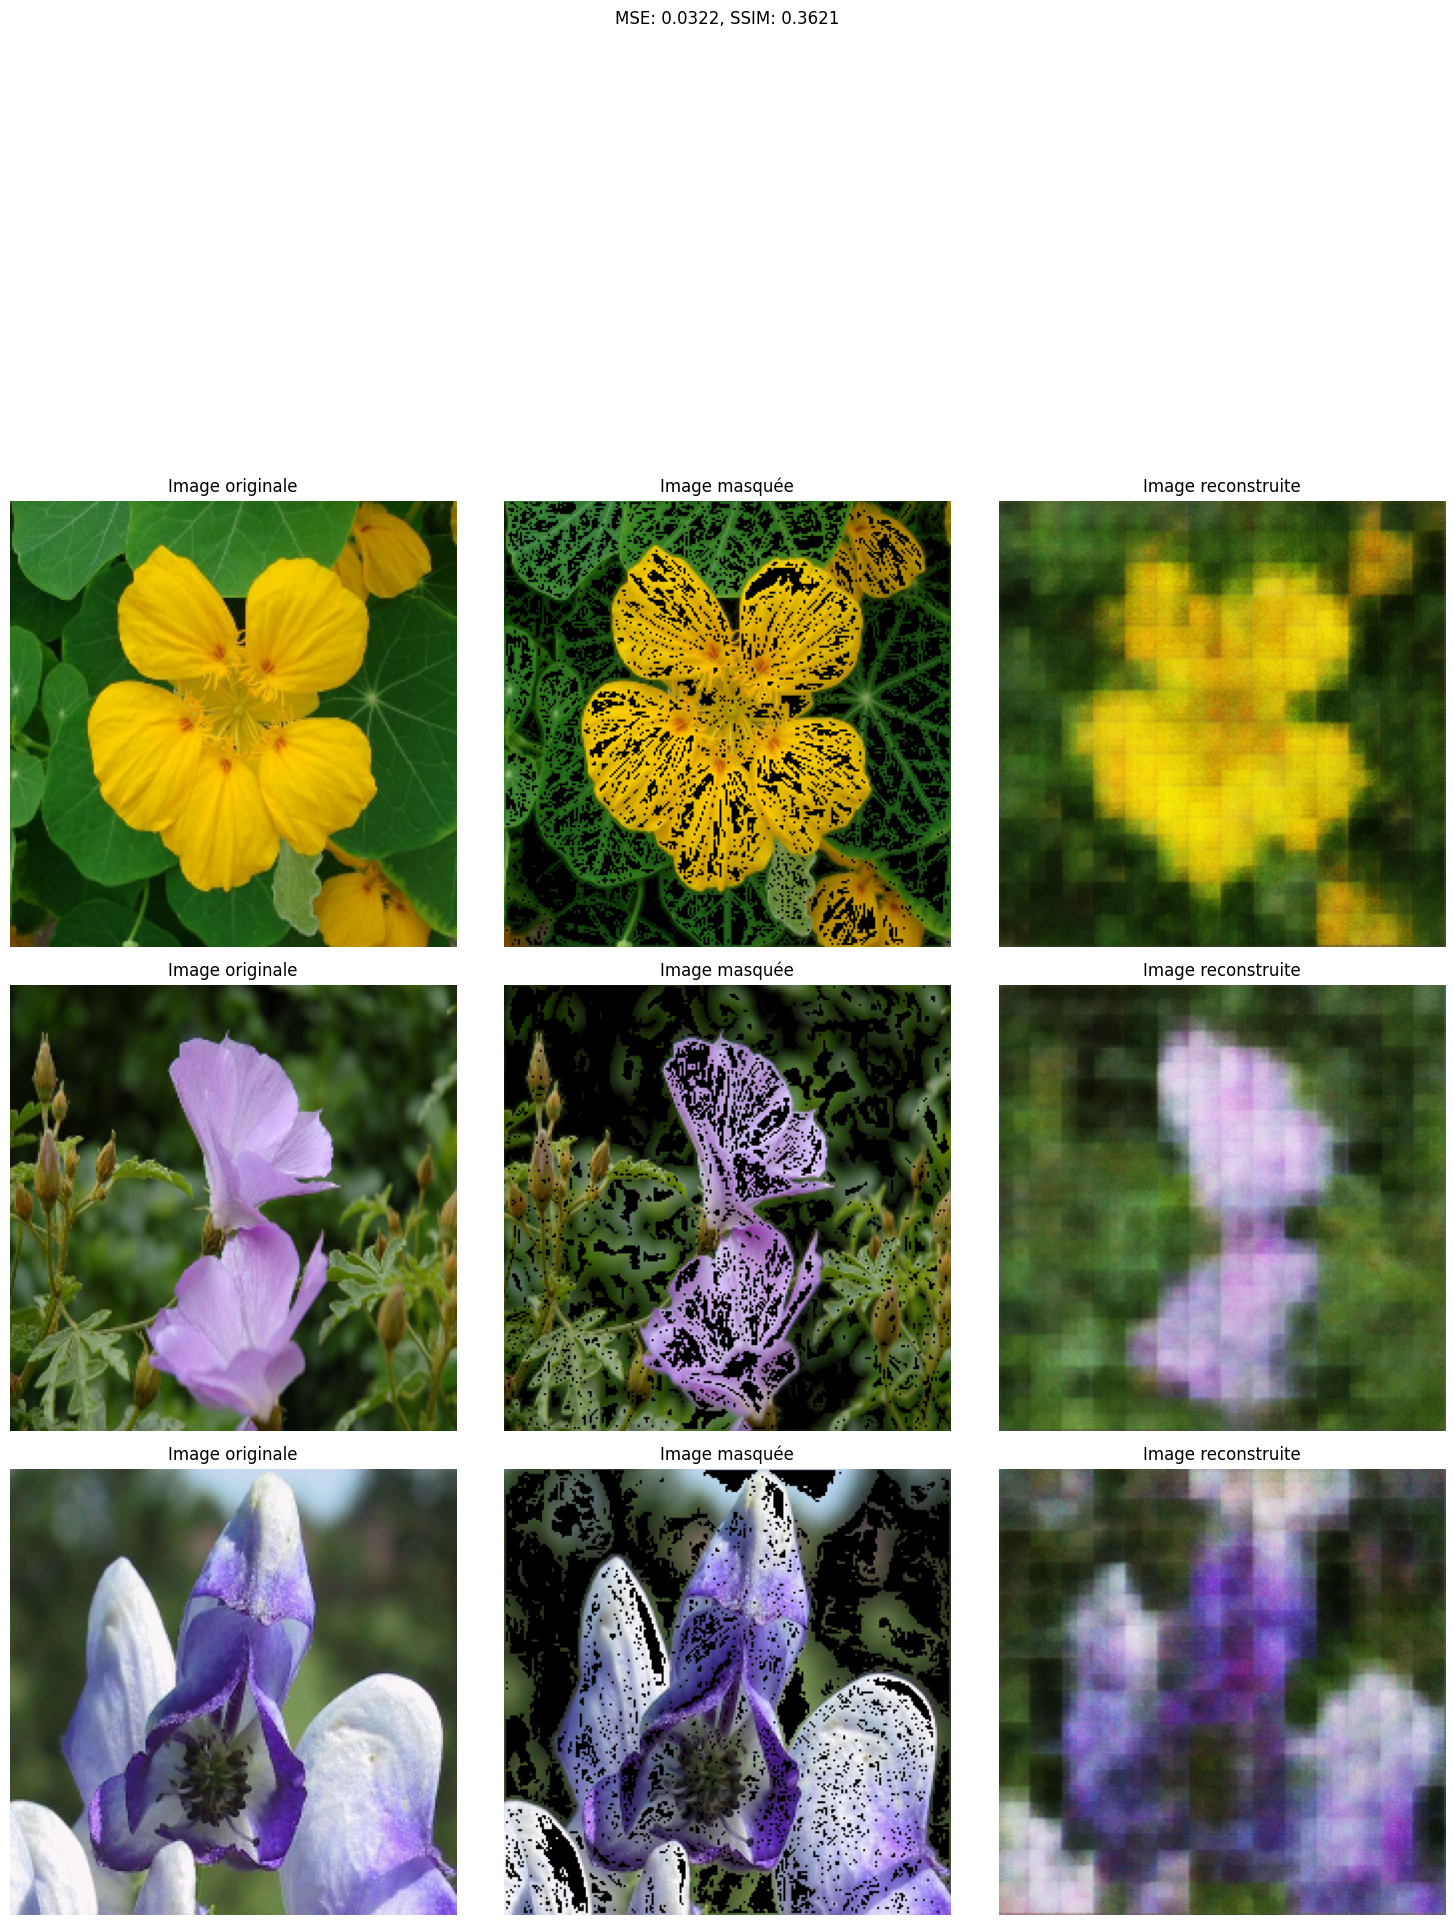

In [19]:
# Run the experiment
if __name__ == "__main__":
    # Make sure TensorFlow is optimized
    tf.config.optimizer.set_jit(True)  # Enable XLA where supported

    # For multi-GPU setups, use MirroredStrategy
    try:
        strategy = tf.distribute.MirroredStrategy()
        print(f"Training with {strategy.num_replicas_in_sync} devices")
    except:
        strategy = tf.distribute.get_strategy()

    with strategy.scope():
        main_importance_masking()